In [1]:
!pip install roboflow pycocotools tqdm matplotlib torchvision
!pip install -q segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 866.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21

In [2]:
from roboflow import Roboflow

rf = Roboflow(api_key="5pEbFhHuFiYqILdQqK0r")
project = rf.workspace("questao2").project("spine_det-alvah")
version = project.version(1)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to spine_det-1 in coco:: 100%|██████████| 2615/2615 [00:00<00:00, 4383.79it/s]


In [3]:
import os
import torch
import torchvision
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.transforms import functional as F
from torchvision.utils import draw_segmentation_masks
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
import json
from pycocotools.coco import COCO
from torchvision import transforms
from sklearn.metrics import f1_score
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp

In [4]:
class CocoSegmentationDataset(CocoDetection):
    def __init__(self, img_folder, ann_file, transforms=None):
        super().__init__(img_folder, ann_file)
        self._transforms = transforms

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        ann_ids = self.coco.getAnnIds(imgIds=self.ids[idx])
        anns = self.coco.loadAnns(ann_ids)

        mask = np.zeros((img.size[1], img.size[0]), dtype=np.uint8)
        for ann in anns:
            # Verifica se a anotação tem um polígono/RLE válido
            if not ann["segmentation"]:  # Filtra segmentações vazias
                continue

            try:
                cat_id = ann['category_id']
                rle = self.coco.annToMask(ann)  # Gera a máscara binária
                mask[rle > 0] = cat_id  # Atribui o category_id às regiões segmentadas
            except Exception as e:
                print(f"Ignorando anotação inválida (ID {ann['id']}): {e}")
                continue

        mask = Image.fromarray(mask)

        if self._transforms:
            img, mask = self._transforms(img, mask)

        img = transforms.functional.to_tensor(img)
        mask = torch.from_numpy(np.array(mask)).long()

        return img, mask

In [5]:
class CustomTransform():
    def __call__(self, img, mask):
        img = transforms.functional.resize(img, (512, 512))
        mask = transforms.functional.resize(mask, (512, 512), interpolation=transforms.InterpolationMode.NEAREST)
        return img, mask

def get_loader(folder, batch_size=4):
    img_dir = os.path.join(folder)
    ann_path = os.path.join(folder, "_annotations.coco.json")
    dataset = CocoSegmentationDataset(img_dir, ann_path, transforms=CustomTransform())
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

# Cria os DataLoaders
train_loader = get_loader(dataset.location + "/train")
val_loader = get_loader(dataset.location + "/valid")
test_loader = get_loader(dataset.location + "/test")

loading annotations into memory...
Done (t=0.39s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [6]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for imgs, masks in tqdm(loader, desc="Treinando"):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, masks.long())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)


def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, masks in tqdm(loader):
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            y_pred.extend(preds.flatten())
            y_true.extend(masks.cpu().numpy().flatten())
    f1 = f1_score(y_true, y_pred, average='macro')
    return f1

In [ ]:
# Configuração do dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modelo DeepLabV3+ com encoder ResNet-50
model = smp.DeepLabV3Plus(
    encoder_name="resnet50",        # backbone
    encoder_weights="imagenet",     # pesos pré-treinados
    in_channels=3,                  # RGB
    classes=2                       # fundo e escoliose
).to(device)


# CrossEntropy para segmentação com 2 classes
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

n_epochs = 25
for epoch in range(n_epochs):
    print(f"\nÉpoca {epoch+1}/{n_epochs}")
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_f1 = evaluate(model, val_loader)
    print(f"Loss de treino: {train_loss:.4f} | F1 Val: {val_f1:.4f}")


Época 1/25


100%|██████████| 25/25 [00:06<00:00,  3.72it/s]


Loss de treino: 0.1301 | F1 Val: 0.8964

Época 2/25


100%|██████████| 25/25 [00:07<00:00,  3.26it/s]


Loss de treino: 0.0539 | F1 Val: 0.8969

Época 3/25


100%|██████████| 25/25 [00:06<00:00,  3.68it/s]


Loss de treino: 0.0413 | F1 Val: 0.9031

Época 4/25


100%|██████████| 25/25 [00:07<00:00,  3.30it/s]


Loss de treino: 0.0394 | F1 Val: 0.9098

Época 5/25


100%|██████████| 25/25 [00:06<00:00,  3.72it/s]


Loss de treino: 0.0309 | F1 Val: 0.9112

Época 6/25


100%|██████████| 25/25 [00:07<00:00,  3.25it/s]


Loss de treino: 0.0254 | F1 Val: 0.9113

Época 7/25


100%|██████████| 25/25 [00:06<00:00,  3.75it/s]


Loss de treino: 0.0224 | F1 Val: 0.9119

Época 8/25


100%|██████████| 25/25 [00:07<00:00,  3.29it/s]


Loss de treino: 0.0205 | F1 Val: 0.9100

Época 9/25


100%|██████████| 25/25 [00:07<00:00,  3.47it/s]


Loss de treino: 0.0189 | F1 Val: 0.9122

Época 10/25


100%|██████████| 25/25 [00:07<00:00,  3.35it/s]


Loss de treino: 0.0280 | F1 Val: 0.9003

Época 11/25


100%|██████████| 25/25 [00:06<00:00,  3.71it/s]


Loss de treino: 0.0243 | F1 Val: 0.9085

Época 12/25


100%|██████████| 25/25 [00:07<00:00,  3.24it/s]


Loss de treino: 0.0170 | F1 Val: 0.9129

Época 13/25


100%|██████████| 25/25 [00:06<00:00,  3.73it/s]


Loss de treino: 0.0154 | F1 Val: 0.9143

Época 14/25


100%|██████████| 25/25 [00:07<00:00,  3.27it/s]


Loss de treino: 0.0149 | F1 Val: 0.9149

Época 15/25


100%|██████████| 25/25 [00:06<00:00,  3.72it/s]


Loss de treino: 0.0143 | F1 Val: 0.9140

Época 16/25


100%|██████████| 25/25 [00:07<00:00,  3.33it/s]


Loss de treino: 0.0141 | F1 Val: 0.9136

Época 17/25


100%|██████████| 25/25 [00:07<00:00,  3.49it/s]


Loss de treino: 0.0136 | F1 Val: 0.9133

Época 18/25


100%|██████████| 25/25 [00:07<00:00,  3.31it/s]


Loss de treino: 0.0132 | F1 Val: 0.9155

Época 19/25


100%|██████████| 25/25 [00:07<00:00,  3.45it/s]


Loss de treino: 0.0126 | F1 Val: 0.9131

Época 20/25


100%|██████████| 25/25 [00:07<00:00,  3.29it/s]


Loss de treino: 0.0125 | F1 Val: 0.9143

Época 21/25


100%|██████████| 25/25 [00:07<00:00,  3.54it/s]


Loss de treino: 0.0150 | F1 Val: 0.8772

Época 22/25


100%|██████████| 25/25 [00:07<00:00,  3.41it/s]


Loss de treino: 0.0222 | F1 Val: 0.9145

Época 23/25


100%|██████████| 25/25 [00:07<00:00,  3.51it/s]


Loss de treino: 0.0117 | F1 Val: 0.9139

Época 24/25


100%|██████████| 25/25 [00:07<00:00,  3.29it/s]


Loss de treino: 0.0109 | F1 Val: 0.9145

Época 25/25


100%|██████████| 25/25 [00:06<00:00,  3.70it/s]


Loss de treino: 0.0106 | F1 Val: 0.9135



Visualizando previsões...


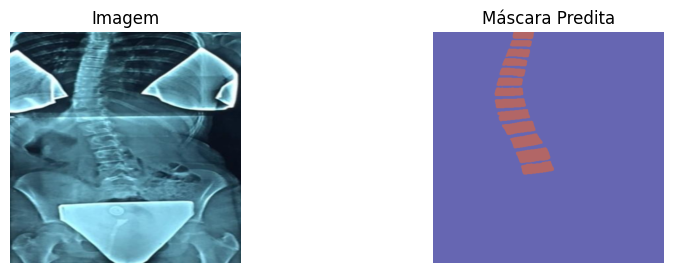

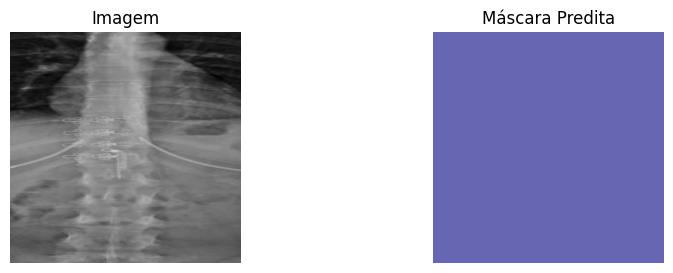

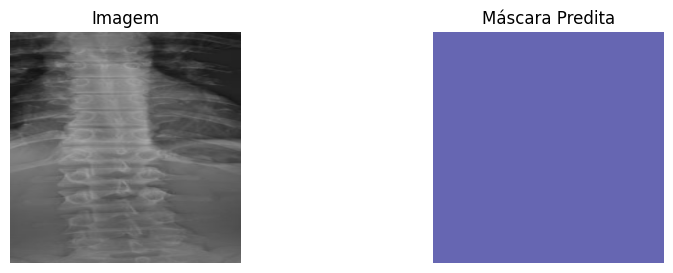

In [21]:
def show_predictions(model, loader, n=3):
    model.eval()
    imgs, masks = next(iter(loader))
    imgs, masks = imgs.to(device), masks.to(device)
    with torch.no_grad():
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)

    for i in range(n):
        img = imgs[i].cpu()
        mask = preds[i].cpu().numpy()

        plt.figure(figsize=(10,3))
        plt.subplot(1,2,1)
        plt.title("Imagem")
        plt.imshow(img.permute(1,2,0))
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.title("Máscara Predita")
        plt.imshow(mask, cmap='jet', alpha=0.6)
        plt.axis('off')
        plt.show()

print("\nVisualizando previsões...")
show_predictions(model, test_loader)

In [ ]:
# Salvar
torch.save(model.state_dict(), "deeplabv3plus_escoliose25.pth")

In [20]:
import segmentation_models_pytorch as smp
import torch

# Configuração do dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recria o modelo com exatamente a mesma configuração
model = smp.DeepLabV3Plus(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=2
).to(device)

# Carrega os pesos corretamente
model.load_state_dict(torch.load("deeplabv3plus_escoliose25.pth"))

# Coloca em modo de avaliação
model.eval()


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia